# Speeding up your Neural Network with Theano and the GPU

In the [previous blog post](http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/) we build a simple Neural Network from scratch. Now, let's speed up our code using the [Theano](http://deeplearning.net/software/theano/) library. As a side effect of using Theano our code will not only become faster, but also more concise!

### What is Theano?

Theano describes itself as a Python library that lets you to define, optimize, and evaluate mathematical expressions, especially ones with multi-dimensional arrays. The way I understand Theano is that it allows me to define **graphs of computations**. Under the hood Theano optimizes these computations in a [variety of ways](http://deeplearning.net/software/theano/introduction.html#introduction), including avoiding redundant computations, generating optimized C code, and using the GPU. Theano also includes the capability to automatically [differentiate](http://deeplearning.net/software/theano/tutorial/gradients.html) mathematical expressions. And because it models computations as graphs it can calculate complex gradients by applying the chain rule. This means we no longer need to compute the gradients ourselves!

Because Neural Networks are easily expressed as graphs of computations Theano is a great fit. In fact, Neural Networks are probably the main use case for Theano. As such, Theano includes several [convenience functions](http://deeplearning.net/software/theano/library/tensor/nnet/index.html#module-nnet) for neural networks. 

### The Setup

The setup is identical to that in [Implementing a Neural Network from Scratch](http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/), so I'll just quickly recap: We have two classes (red and blue) and we want to train a Neural Network classifier that separates the two. We will train a 3-layer Neural Network, with input layer size 2, output layer size 2, and hidden layer size 3. We will use batch gradient descent with a fixed learning rate to train our network. 

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import matplotlib
import theano
import theano.tensor as T
import pydot
from IPython.display import Image
from IPython.display import SVG

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

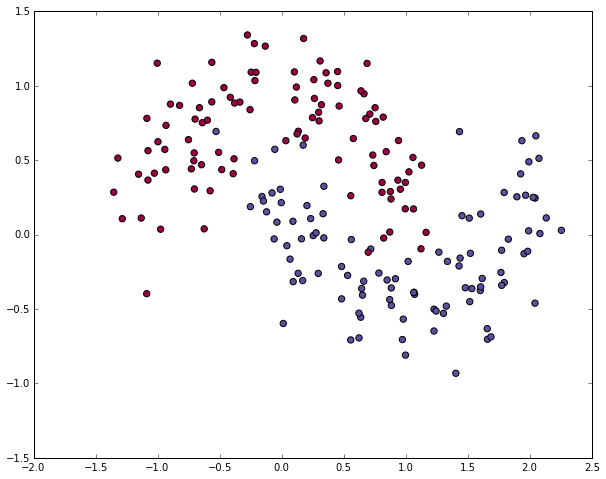

In [13]:
# Generate a dataset and plot it
np.random.seed(0)
train_X, train_y = sklearn.datasets.make_moons(200, noise=0.20)
plt.scatter(train_X[:,0], train_X[:,1], s=40, c=train_y, cmap=plt.cm.Spectral)

In [14]:
# Helper function to plot a decision boundary.
# If you don't fully understand this function don't worry, it just generates the contour plot.
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = train_X[:, 0].min() - .5, train_X[:, 0].max() + .5
    y_min, y_max = train_X[:, 1].min() - .5, train_X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_y, cmap=plt.cm.Spectral)

In [26]:
# Size definitions
num_examples = len(train_X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality
nn_hdim = 3 # hiden layer dimensionality

# Gradient descent parameters (I picked these by hand)
epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength 

### Defining the Computation Graph

Now let's use Theano to define our computations. We start by defining our input data matrix `X` and our training labels `y`:

In [37]:
# Our data vectors
X = T.dmatrix('X') # matrix of doubles
y = T.lvector('y') # vector of int64

Now, here's crucial thing to understand: We have not assigned any values to `X` or `y`. All we have done is defined mathematical expressions for them that we can use in subsequent calcuations. If we wanted to evaluate an expression we can call its `eval` method. For example, to evaluate the expression `X * 2` for a given value of `X` we could do the following:

In [38]:
(X * 2).eval({X : [[1,1],[2,2]] })

array([[ 2.,  2.],
       [ 4.,  4.]])

Theano handles the type checking for us. Trying to assign a non-matrix X would result in an error. [Here is the full list of Theano types](http://deeplearning.net/software/theano/library/tensor/basic.html#all-fully-typed-constructors).

Theano has another type of variable called [shared variables](http://deeplearning.net/software/theano/tutorial/examples.html#using-shared-variables). The key difference is that these variables have an internal state associated with them, an actual value that is kept in memory and shared by all functions that use them. Shared variables can also be updated, and Theano includes low-level optimizations that makes updating them very efficient, especially on GPUs. Our network parameters $W_1, b_1, W_2, b_2$ are constantly updated using gradient descent, so they are perfect candidates for shared variables:

In [98]:
# Shared variables with initial values. We need to learn these
W1 = theano.shared(np.random.randn(nn_input_dim, nn_hdim), name='W1')
b1 = theano.shared(np.zeros(nn_hdim), name='b1')
W2 = theano.shared(np.random.randn(nn_hdim, nn_output_dim), name='W2')
b2 = theano.shared(np.zeros(nn_output_dim), name='b2')

Next, let's define expressions for our forward propagation. The calculations are identical to the ones we used in our pure numpy implementation, just that we are defining Theano expressions now. Again, remember that these expressions are not evaluated yet, we are just defining them. You can think of them as lambda expressions that require input values if we want to evaluate them. We are also using some of Theano's conveninence functions like [nnet.softmax](http://deeplearning.net/software/theano/library/tensor/nnet/nnet.html#tensor.nnet.softmax) and [nnet.categorical_crossentropy](http://deeplearning.net/software/theano/library/tensor/nnet/nnet.html#tensor.nnet.categorical_crossentropy).

In [87]:
# Forward propagation
# Note: We are just defining the expressions, nothing is evaluated here!
z1 = X.dot(W1) + b1
a1 = T.tanh(z1)
z2 = a1.dot(W2) + b2
y_hat = T.nnet.softmax(z2) # output probabilties

# The regularization term (optional)
loss_reg = 1./num_examples * reg_lambda/2 * (T.sum(T.sqr(W1)) + T.sum(T.sqr(W2))) 
# the loss function we want to optimize
loss = T.nnet.categorical_crossentropy(y_hat, y).mean() + loss_reg

prediction = T.argmax(y_hat, axis=1) # Returns a class prediction

Now is a good time to get a sense of how Theano constructs a computational graph under the hood. Looking at the expressions for $a_1$ we can see that it depends on $z_1$, which in turn depends on $X$, $W_1$ and $b_1$. Theano lets us visualize this:

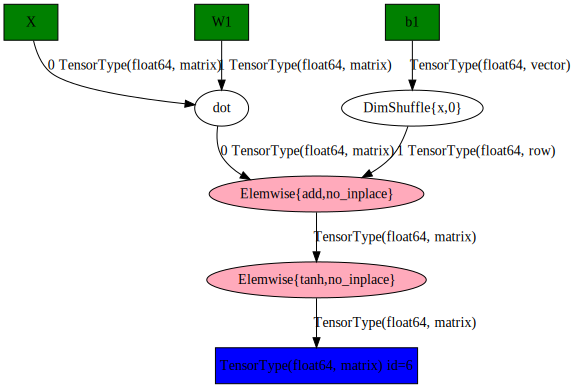

In [88]:
SVG(theano.printing.pydotprint(a1, var_with_name_simple=True, compact=True, return_image=True, format='svg'))

Above we saw how we can evaluate a Theano expression by calling its `eval` method. A much more convient way is to create a [function](http://deeplearning.net/software/theano/library/compile/function.html#function.function) for expressions we want to calculate. To create a function we need to define its inputs and outputs. Once created, we can call the resulting function just like any other Python function.

In [89]:
# Theano functions that can be called from our Python code
forward_prop = theano.function([X], y_hat)
calculate_loss = theano.function([X, y], loss)
predict = theano.function([X], prediction)

# Example call: Forward Propagation
forward_prop([[1,2]])

array([[  9.99859855e-01,   1.40145199e-04]])

Let's take a look at what the computation graph for the forward propagation function looks like:

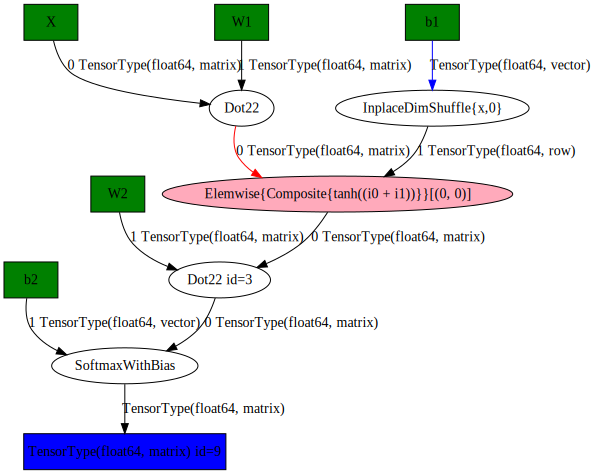

In [100]:
# theano.printing.pydotprint(forward_prop, outfile="img/theano_forward_prop.png", var_with_name_simple=True, compact=True)
# theano.printing.pydotprint(predict, outfile="img/theano_predict.png", var_with_name_simple=True, compact=True)
# theano.printing.pydotprint(calculate_loss, outfile="img/theano_calculate_loss.png", var_with_name_simple=True, compact=True)
# theano.printing.pydotprint(gradient_step, outfile="img/theano_gradient_step.png", var_with_name_simple=True, compact=True)
SVG(theano.printing.pydotprint(forward_prop, var_with_name_simple=True, compact=True, return_image=True, format='svg'))

What's left now is defining our updates to the network parameters. We need to calculate the gradients using backpropagation. We could do this manually and use code similar to our original NumPy network (see code that's commented out below), but it's much easier if we let Theano calculate the derivatives for us! We need the derivates of our loss function $L$ with respect to our parameters: $\frac{\partial L}{\partial W_2}$, $\frac{\partial L}{\partial b_2}$, $\frac{\partial L}{\partial W_1}$, $\frac{\partial L}{\partial b_1}$:

In [92]:
# Easy: Let Theano calculate the derivatives for us!
dW2 = T.grad(loss, W2)
db2 = T.grad(loss, b2)
dW1 = T.grad(loss, W1)
db1 = T.grad(loss, b1)

# Backpropagation (Manual)
# Note: We are just defining the expressions, nothing is evaluated here!
# y_onehot = T.eye(2)[y]
# delta3 = y_hat - y_onehot
# dW2 = (a1.T).dot(delta3) * (1. + reg_lambda)
# db2 = T.sum(delta3, axis=0)
# delta2 = delta3.dot(W2.T) * (1. - T.sqr(a1))
# dW1 = T.dot(X.T, delta2) * (1 + reg_lambda)
# db1 = T.sum(delta2, axis=0)

Because we defined $W_2, b_2, W_1, b_1$ as shared variables we can use Theano's efficient update mechanism to update their values. The following function without return value does a single gradient descent update:

In [79]:
gradient_step = theano.function(
    [X, y],
    updates=((W2, W2 - epsilon * dW2),
             (W1, W1 - epsilon * dW1),
             (b2, b2 - epsilon * db2),
             (b1, b1 - epsilon * db1)))

Note that we don't need to explicitly do a forward propagation here. Theano knows that our gradients depends on our predictions from the forward propagation and it will handle all the necessary calculations.

Let's now define the function to train our Neural Network using gradent descent. The function is equivalent to what we had in our original code, only that we are now calling the `gradient_step` function defined above instead of doing the calculations inside the loop.

Loss after iteration 0: 0.582899
Loss after iteration 1000: 0.327102
Loss after iteration 2000: 0.306491
Loss after iteration 3000: 0.300981
Loss after iteration 4000: 0.295885
Loss after iteration 5000: 0.289264
Loss after iteration 6000: 0.280672
Loss after iteration 7000: 0.270248
Loss after iteration 8000: 0.258542
Loss after iteration 9000: 0.246241
Loss after iteration 10000: 0.233966
Loss after iteration 11000: 0.222174
Loss after iteration 12000: 0.211141
Loss after iteration 13000: 0.200995
Loss after iteration 14000: 0.191746
Loss after iteration 15000: 0.183330
Loss after iteration 16000: 0.175625
Loss after iteration 17000: 0.168472
Loss after iteration 18000: 0.161684
Loss after iteration 19000: 0.155086


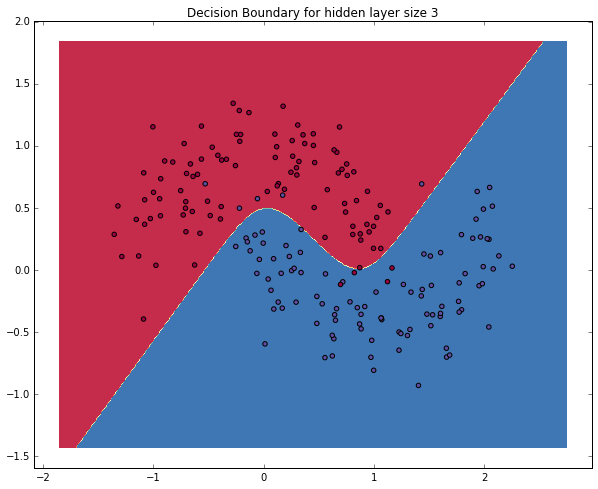

In [97]:
# This function learns parameters for the neural network and returns the model.
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations
def build_model(num_passes=20000, print_loss=False):
    
    # Re-Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1.set_value(np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim))
    b1.set_value(np.zeros(nn_hdim))
    W2.set_value(np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim))
    b2.set_value(np.zeros(nn_output_dim))
    
    # Gradient descent. For each batch...
    for i in xrange(0, num_passes):
        # This will update our parameters W2, b2, W1 and b1!
        gradient_step(train_X, train_y)
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print "Loss after iteration %i: %f" %(i, calculate_loss(train_X, train_y))

            
# Build a model with a 3-dimensional hidden layer
build_model(print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(x))
plt.title("Decision Boundary for hidden layer size 3")

### Running on a GPU



In [ ]:
`g2.2xlarge` instance.